In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
print('pandas: ',pd.__version__)
print('numpy: ', np.__version__)

pandas:  1.1.0
numpy:  1.19.1


In [3]:
df = pd.read_csv('./data/BX-Book-Ratings.csv', sep=';',error_bad_lines=False , encoding='latin-1')
df.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [4]:
df.columns = ['user', 'book', 'rating']
df.head()

,user,book,rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [5]:
print('Original dataset size', df.size)

Original dataset size 3449340


In [6]:
user_min_ratings = 30
book_min_ratings = 20

user_filter = df['user'].value_counts() > user_min_ratings
user_filter = user_filter[user_filter].index.tolist()

book_filter = df['book'].value_counts() > book_min_ratings
book_filter = book_filter[book_filter].index.tolist()

print(f'Original dataset user count: {len(df["user"].unique())}')
print(f'Selecting {len(user_filter)} user with more that {user_min_ratings} ratings')
print(f'Original dataset book count: {len(df["book"].unique())}')
print(f'Selecting {len(book_filter)} books with more that {book_min_ratings} ratings')

df_new = df[df['book'].isin(book_filter) & df['user'].isin(user_filter)].copy(deep=True)

print(f'New dataset size: {len(df_new)}')

Original dataset user count: 105283
Selecting 5132 user with more that 30 ratings
Original dataset book count: 340556
Selecting 7064 books with more that 20 ratings
New dataset size: 265321


In [141]:
user_ids = df_new['user'].unique().tolist()
user2id = {x: i for i, x in enumerate(user_ids)}
id2user = {i: x for i, x in enumerate(user_ids)}
df_new['user_id'] = df_new['user'].map(user2id)

book_ids = df_new['book'].unique().tolist()
book2id = {x: i for i, x in enumerate(book_ids)}
id2book = {i: x for i, x in enumerate(book_ids)}
df_new['book_id'] = df_new['book'].map(book2id)
df_new.head()

,user,book,rating,user_id,book_id
173,276847,0446364193,0,0,0
175,276847,3379015180,0,0,1
182,276847,3426029553,8,0,2
210,276847,3551551677,10,0,3
338,276875,0688172377,0,1,4


In [144]:
max_rating = max(df_new['rating'])
min_rating = min(df_new['rating'])
num_users = len(user_ids)
num_books = len(book_ids)

print('User count', num_users)
print('Book count', num_books)

User count 5032
Book count 7063


In [221]:
df_new["rating"] = df_new["rating"].values.astype(np.float32)
df_new = df_new.sample(frac=1, random_state=42)
x = df_new[["user_id", "book_id"]].values
y = df_new["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

In [155]:
train_indices = int(0.9 * df_new.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [191]:
print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'x_val shape: {x_val.shape}')
print(f'y_val shape: {y_val.shape}')

x_train shape: (238788, 2)
y_train shape: (238788,)
x_val shape: (26533, 2)
y_val shape: (26533,)


In [219]:
EMBEDDING_SIZE = 50

# class RecommenderNet(tf.keras.Model):
#     def __init__(self, num_users, num_books, embedding_size, **kwargs):
#         super(RecommenderNet, self).__init__(**kwargs)
#         self.num_users = num_users
#         self.num_books = num_books
#         self.embedding_size = embedding_size
#         self.user_embedding = layers.Embedding(
#             num_users,
#             embedding_size,
#             embeddings_initializer="he_normal",
#             embeddings_regularizer=keras.regularizers.l2(1e-6),
#         )
#         self.user_bias = layers.Embedding(num_users, 1)
#         self.book_embedding = layers.Embedding(
#             num_books,
#             embedding_size,
#             embeddings_initializer="he_normal",
#             embeddings_regularizer=keras.regularizers.l2(1e-6),
#         )
#         self.book_bias = layers.Embedding(num_books, 1)

#     def call(self, inputs):
#         user_vector = self.user_embedding(inputs[:, 0])
#         user_bias = self.user_bias(inputs[:, 0])
#         book_vector = self.book_embedding(inputs[:, 1])
#         book_bias = self.book_bias(inputs[:, 1])
#         dot_user_book = tf.tensordot(user_vector, book_vector, 2)
#         x = dot_user_book + user_bias + book_bias
#         # The sigmoid activation forces the rating to between 0 and 1
#         return tf.nn.sigmoid(x)

def book_embedding_model(embedding_size=30):
    user = Input(name='user', shape=(1,))
    book = Input(name='book', shape=(1,))
    user_embedding = Embedding(name='user_embedding',
        input_dim=num_users, output_dim=embedding_size)(user)
    book_embedding = Embedding(name='book_embedding',
        input_dim=num_books, output_dim=embedding_size)(book)
    dot = Dot(name='dot_product', normalize=True, axes=2)(
        [user_embedding, book_embedding])
    merged = Reshape((1,))(dot)
    model = Model(inputs=[user, book], outputs=[merged])
    model.compile(optimizer='nadam', loss='mse')
    return model


# model = RecommenderNet(num_users, num_books, EMBEDDING_SIZE)
model = book_embedding_model()
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001/2)
)

In [220]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
book (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 30)        150960      user[0][0]                       
__________________________________________________________________________________________________
book_embedding (Embedding)      (None, 1, 30)        211890      book[0][0]                       
____________________________________________________________________________________________

In [229]:
history = model.fit(
    x=[x_train[:, 0], x_train[:, 1]],
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=([x_val[:, 0], x_val[:, 1]], y_val),
)

Epoch 1/5
3732/3732 [==============================] - 41s 11ms/step - loss: 0.6681 - val_loss: 1.2747
Epoch 2/5
3732/3732 [==============================] - 38s 10ms/step - loss: 0.5988 - val_loss: 1.2324
Epoch 3/5
3732/3732 [==============================] - 43s 12ms/step - loss: 0.5547 - val_loss: 1.1992
Epoch 4/5
3732/3732 [==============================] - 42s 11ms/step - loss: 0.5223 - val_loss: 1.1926
Epoch 5/5
3732/3732 [==============================] - 45s 12ms/step - loss: 0.4978 - val_loss: 1.1769


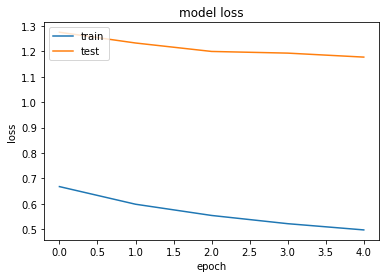

In [230]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [231]:
book_embedding = model.get_layer('book_embedding')
book_weights = book_embedding.get_weights()[0]
lens = np.linalg.norm(book_weights, axis=1)
normalized = (book_weights.T / lens).T

def neighbors(book):
    dists = np.dot(normalized, normalized[book2id[book]])
    closest = np.argsort(dists)[-10:]
    for c in reversed(closest):
        print(c, id2book[c], dists[c])

In [232]:
neighbors('0345339711')

1385 0345339711 0.9999999
1680 0345339738 0.9003818
1679 0345339703 0.8170532
201 0385484518 0.7399914
6114 014034019X 0.68400836
180 0345339681 0.66840315
6133 0312863551 0.65853137
5532 014062063X 0.65327436
1131 0312966970 0.64794093
612 0765341174 0.64677006


In [ ]:
# Saving
np.save('./data/book_embedding_weights', book_weights)
np.save('./data/book_2_id', book2id)
np.save('./data/id_2_book', id2book)

In [ ]:
df_books = pd.read_csv('./data/BX-Books.csv', sep=';',error_bad_lines=False , encoding='latin-1')
df_books = df_books.drop(
    ['Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L'],
    axis=1
)
df_books = df_books[df_books['ISBN'].isin(book_filter)].copy()
np.save('./data/reduced-books', df_books.values)